# Imports

In [1]:
import sys

from utils import (load_data, CLASSIFICATION, REGRESSION, save_conf_matrix, 
                  TRAIN, TEST, MakiKFoldBalance, foldername2class)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(2)
import time

import numpy as np
from matplotlib import pyplot
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers as L
from tensorflow.keras import initializers

import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
from sklearn.utils import shuffle

# Global constants

In [6]:
# Target size
H, W, C = (128, 128, 3)
BATCH_SIZE = 10

SAVE_RESULT = "/raid/rustam/danil/beams_test/beams_gan_train"

LATEN_DIM = 100

TRAIN_PATH = '../../double_modes'
PRINT_RESULTS = True

foldername2class = {
	'0.0':  0,
	'0.05': 1,
	'0.1':  2,
	'0.15': 3,
	'0.2':  4,
	'0.25': 5,
	'0.3':  6,
	'0.35': 7,
	'0.4':  8,
	'0.45': 9,
	'0.5':  10,
	'0.55': 11,
	'0.6':  12,
	'0.65': 13,
	'0.7':  14,
	'0.75': 15,
	'0.8':  16,
	'0.85': 17,
	'0.9':  18,
	'0.95': 19,
	'1.0':  20,
}


N_CLASSES = len(foldername2class)

# Create tf.dataset pipeline

In [7]:
def depreprocess_images(images):
    images = (images + 1.0) / 2.0
    return images

@tf.function
def normalize_data(Xdata, Ydata):
    Xdata = tf.cast(Xdata, tf.float32)
    Xdata -= 127.5
    Xdata /= 127.5
    return Xdata, Ydata

@tf.function
def aug_noise(Xdata, Ydata):
    Xdata = tf.cast(Xdata, tf.float32)
    Xdata -= tf.random.normal(tf.shape(Xdata)) * 3.14 * 3
    return Xdata, Ydata

@tf.function
def aug_rotate(Xdata, Ydata, min_angle=0, max_angle=180):
    Xdata = tfa.image.rotate(
        Xdata,
        tf.random.uniform((tf.shape(Xdata)[0],), min_angle, max_angle),
        interpolation='bilinear', #bilinear
        fill_mode='constant' #nearest wrap constant reflect
    )
    return Xdata, Ydata

def data_gen(Xdata, Ydata):
    counter = 0
    Xdata, Ydata = shuffle(Xdata, Ydata)
    while True:
        yield Xdata[counter], Ydata[counter]
        
        counter += 1
        if counter == len(Xdata):
            Xdata, Ydata = shuffle(Xdata, Ydata)
            counter = 0

def create_dataset(Xdata, Ydata, batch_size):
    tf_dataset = tf.data.Dataset.from_generator(
        lambda: data_gen(Xdata, Ydata),
        output_signature=(
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int32),
        )
    )
    tf_dataset = tf_dataset.cache()
    tf_dataset = tf_dataset.shuffle(batch_size * 6, reshuffle_each_iteration=True)
    tf_dataset = tf_dataset.batch(batch_size)
    tf_dataset = tf_dataset.map(aug_rotate, num_parallel_calls=tf.data.AUTOTUNE)
    # Do not use it - it destroy results
#    tf_dataset = tf_dataset.map(aug_noise, num_parallel_calls=tf.data.AUTOTUNE)
    tf_dataset = tf_dataset.map(normalize_data, num_parallel_calls=tf.data.AUTOTUNE)
    tf_dataset = tf_dataset.prefetch(4)
    return tf_dataset

In [8]:
os.makedirs(SAVE_RESULT, exist_ok=True)

# At start of each experiments - create new dataset (shuffle it)
Xtrain, Ytrain, Xtest, Ytest, pred2params, config_data = load_data(
    path_exp_folder=SAVE_RESULT,
    path_to_data=TRAIN_PATH,
    use_saved=False,
    size_hw=(128, 128),
    test_percent=0.0,
    data_type=CLASSIFICATION
)
train_size = 30_000
Ytrain = np.asarray(Ytrain).astype(np.int32)
Ytest = np.asarray(Ytest).astype(np.int32)

16it [00:00, 156.69it/s]

Generate new data...
21


50it [00:00, 189.77it/s]
50it [00:00, 211.56it/s]
50it [00:00, 220.35it/s]
50it [00:00, 260.11it/s]
50it [00:00, 259.55it/s]
50it [00:00, 259.12it/s]
50it [00:00, 258.63it/s]
50it [00:00, 258.85it/s]
50it [00:00, 259.59it/s]
50it [00:00, 260.48it/s]
50it [00:00, 262.14it/s]
50it [00:00, 265.56it/s]
50it [00:00, 268.98it/s]
50it [00:00, 270.51it/s]
50it [00:00, 274.14it/s]
50it [00:00, 276.53it/s]
50it [00:00, 278.69it/s]
50it [00:00, 281.00it/s]
50it [00:00, 281.12it/s]
50it [00:00, 281.40it/s]
50it [00:00, 282.46it/s]

train :  1029
test:  21


In [9]:
dataset = create_dataset(Xtrain, Ytrain, BATCH_SIZE)

# Load data

In [10]:
# Load train data
data_iter = iter(dataset)

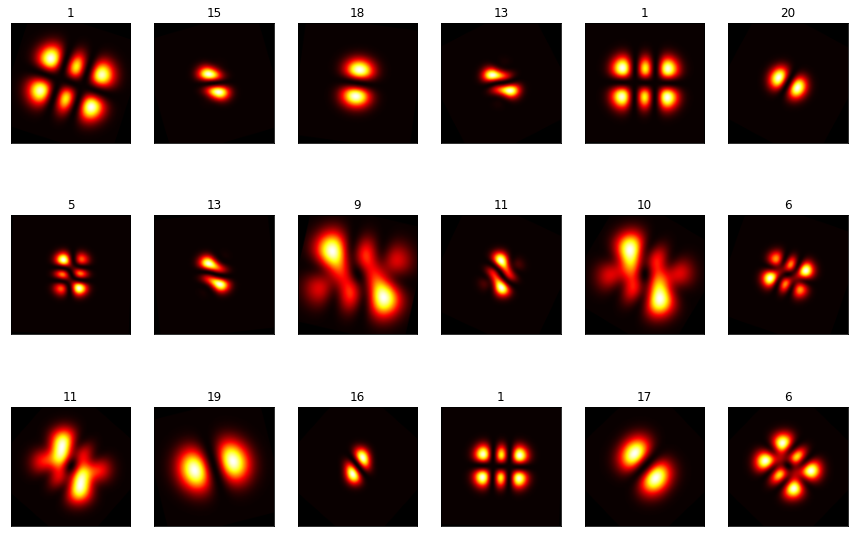

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
indx = 0
for i, (ax, (img, label_leg)) in enumerate(zip(axes.flat, dataset)):
    ax.imshow(depreprocess_images(img[0]))
    ax.set_title(int(label_leg[0]))
    
plt.show()

# Define additional layers

In [12]:
class ConditionalBatchNormalization(tf.keras.Model):
    """
    https://github.com/crcrpar/pytorch.sngan_projection/blob/master/links/conditional_batchnorm.py
    Conditional Batch Normalization Base Class
    """

    def __init__(self, 
               num_classes,
               units,
               axis=-1,
               momentum=0.99,
               epsilon=1e-3,
               center=False,
               scale=False,
               beta_initializer='zeros',
               gamma_initializer='ones',
               moving_mean_initializer='zeros',
               moving_variance_initializer='ones',
               beta_regularizer=None,
               gamma_regularizer=None,
               beta_constraint=None,
               gamma_constraint=None,
               renorm=False,
               renorm_clipping=None,
               renorm_momentum=0.99,
               fused=None,
               trainable=True,
               virtual_batch_size=None,
               adjustment=None,
               name=None,
               **kwargs):
        super(ConditionalBatchNormalization, self).__init__(name, **kwargs)
        self.weight_embedding = L.Embedding(input_dim=num_classes, output_dim=units, input_length=1, embeddings_initializer='ones')
        self.bias_embedding = L.Embedding(input_dim=num_classes, output_dim=units, input_length=1, embeddings_initializer='zeros')
        self.bn = L.BatchNormalization(axis=-1,
               momentum=0.99,
               epsilon=1e-3,
               center=False,
               scale=False,
               beta_initializer='zeros',
               gamma_initializer='ones',
               moving_mean_initializer='zeros',
               moving_variance_initializer='ones',
               beta_regularizer=None,
               gamma_regularizer=None,
               beta_constraint=None,
               gamma_constraint=None,
               renorm=False,
               renorm_clipping=None,
               renorm_momentum=0.99,
               fused=None,
               trainable=True,
               virtual_batch_size=None,
               adjustment=None,)

    def call(self, inputs, training=None):
        """Call `Layer`"""
        
        class_weights = self.weight_embedding(inputs[1])
        class_bias = self.bias_embedding(inputs[1])

        if len(class_weights.shape) == 3:
            class_weights = tf.squeeze(class_weights, [1])
        if len(class_bias.shape) == 3:
            class_bias =tf.squeeze(class_bias, [1])
        
        output = self.bn(inputs[0], training=training)
        
        if len(class_weights.shape) == 1:
            class_weights = tf.expand_dims(class_weights, 0)
        if len(class_bias.shape) == 1:
            class_bias = tf.expand_dims(class_bias, 0)
            
        
        class_weights = class_weights[:, tf.newaxis, tf.newaxis, :]
        class_bias = class_bias[:, tf.newaxis, tf.newaxis, :]
        output = class_weights * output + class_bias
        return output
    
    def compute_output_shape(self, input_shape):
        return tensor_shape.TensorShape(input_shape[0])

class SpectralNormalization(tf.keras.layers.Wrapper):
    """
    Reference from WeightNormalization implementation of TF Addons
    SpectralNormalization wrapper works for keras CNN and Dense (RNN not tested).
    ```python
      net = SpectralNormalization(
          tf.keras.layers.Conv2D(2, 2, activation='relu'),
          input_shape=(32, 32, 3))(x)
    ```
    Arguments:
      layer: a layer instance.
    Raises:
      ValueError: If `Layer` does not contain a `kernel` of weights
    """

    def __init__(self, layer, power_iter=1, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)
        self._track_trackable(layer, name='layer')
        self.power_iter = 1
        self.is_rnn = isinstance(self.layer, tf.keras.layers.RNN)
        self.is_embedding = isinstance(self.layer, tf.keras.layers.Embedding)

    def build(self, input_shape):
        """Build `Layer`"""
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = tf.keras.layers.InputSpec(
            shape=[None] + input_shape[1:])

        if not self.layer.built:
            self.layer.build(input_shape)

        if self.is_rnn:
            kernel_layer = self.layer.cell
        else:
            kernel_layer = self.layer

        if not hasattr(kernel_layer, 'kernel') and not hasattr(kernel_layer, 'embeddings'):
            raise ValueError('`SpectralNormalization` must wrap a layer that'
                             ' contains a `kernel or embedding` for weights')

        if self.is_rnn:
            kernel = kernel_layer.recurrent_kernel
        elif self.is_embedding:
            kernel = kernel_layer.embeddings
        else:
            kernel = kernel_layer.kernel
            
        self.kernel_shape = kernel.shape
        
        self.u = self.add_weight(name='u',
                             shape=(self.kernel_shape[-1], 1),
                             initializer='random_normal',
                             trainable=False)
        self.w = kernel
        self.built = True
    
    def call(self, inputs, training=True):
        """Call `Layer`"""

        with tf.name_scope('compute_weights'):
            
            weight = tf.reshape(self.w, shape=[self.kernel_shape[-1], -1])
            # power iteration
            for i in range(self.power_iter):
                v = tf.math.l2_normalize(tf.matmul(tf.transpose(weight), self.u))
                u = tf.math.l2_normalize(tf.matmul(weight, v))
            v = tf.stop_gradient(v)
            u = tf.stop_gradient(u)
            
            sigma = tf.matmul(tf.matmul(tf.transpose(u), weight), v)
            kernel = self.w / sigma

            if self.is_rnn:
                print(self.is_rnn)
                self.layer.cell.recurrent_kernel = kernel
                update_kernel = tf.identity(self.layer.cell.recurrent_kernel)
            else:
                self.layer.kernel = kernel
                update_kernel = tf.identity(self.layer.kernel)

            # Ensure we calculate result after updating kernel.
            with tf.control_dependencies([update_kernel]):
                outputs = self.layer(inputs)
                return outputs

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())
    
class GlobalSumPooling2D(tf.keras.layers.Layer):
    def __init__(self, data_format='channels_last', **kwargs):
        super(GlobalSumPooling2D, self).__init__(**kwargs)
        self.input_spec = L.InputSpec(ndim=4)
        self.data_format = conv_utils.normalize_data_format(data_format)
    
    def call(self, inputs):
        if self.data_format == 'channels_last':
            return tf.reduce_sum(inputs, axis=(1, 2))
        else:
            return tf.reduce_sum(inputs, axis=(2, 3))
    
    def get_config(self):
        config = {'data_format': self.data_format}
        base_config = super(GlobalSumPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()
        if self.data_format == 'channels_last':
            return tensor_shape.TensorShape([input_shape[0], input_shape[3]])
        else:
            return tensor_shape.TensorShape([input_shape[0], input_shape[1]])

# Define models

In [13]:
def init_weights():
    return initializers.RandomNormal(stddev=0.02)

def init_weights():
    return 'glorot_uniform'

In [14]:

class UpsampleResidualBlock(tf.Module):

    def __init__(
            self, in_f: int, out_f: int, num_classes: int, k=3, s=1, 
            padding='same', activation=tf.nn.leaky_relu, upsample=True, name='',
            kernel_initializer = 'glorot_uniform'):
        self.in_f = in_f
        self.out_f = out_f
        self.x1 = ConditionalBatchNormalization(
            num_classes=num_classes, units=in_f
        )
        self.x2 = L.Activation(activation)
        self.upsample = upsample
        if upsample:
            self.x1_up = L.UpSampling2D(size=2, interpolation='nearest')
        self.x3 = L.Conv2D(
            out_f, k, s, padding=padding, 
            kernel_initializer=kernel_initializer
        ) 
        self.x4 = ConditionalBatchNormalization(
            num_classes=num_classes, units=out_f
        )
        self.x5 = L.Activation(activation)
        self.x6 = L.Conv2D(
            out_f, k, s, padding=padding, 
            kernel_initializer=kernel_initializer
        ) 

        if in_f != out_f or upsample:
            if upsample:
                self.x_in_up1 = L.UpSampling2D(size=2, interpolation='nearest')
            self.x_in_pointwise = L.Conv2D(
                out_f, 1, 1, padding='valid',
                kernel_initializer=kernel_initializer
            )

    @tf.function
    def __call__(self, x_in, y_class, training=False):
        x = self.x1([x_in, tf.cast(y_class, dtype=tf.int32)], training=training)
        x = self.x2(x, training=training)
        
        if self.upsample:
            x = self.x1_up(x, training=training)
        
        x = self.x3(x, training=training)
        
        x = self.x4([x, tf.cast(y_class, dtype=tf.int32)], training=training)
        x = self.x5(x, training=training)
        x = self.x6(x, training=training)
        
        if self.in_f != self.out_f or self.upsample:
            if self.upsample:
                x_in = self.x_in_up1(x_in, training=training)
            x_in = self.x_in_pointwise(x_in, training=training)
        
        x += x_in
        return x



In [15]:

class InitialDownsampleBlock(tf.Module):

    def __init__(
            self, in_f: int, out_f: int, k=3, s=1, 
            padding='same', activation=tf.nn.leaky_relu, name='',
            kernel_initializer = 'glorot_uniform'):
        self.in_f = in_f
        self.out_f = out_f
        self.x1 = SpectralNormalization(L.Conv2D(
            out_f, k, s, padding=padding,
            kernel_initializer=kernel_initializer
        ))
        self.x2 = L.Activation(activation)
        self.x3 = SpectralNormalization(L.Conv2D(
            out_f, k, s, 
            padding=padding, kernel_initializer=kernel_initializer
        ))
        
        self.x4 = L.AveragePooling2D(pool_size=2)
        
        self.x_in1 = L.AveragePooling2D(pool_size=2)
        self.x_in2 = SpectralNormalization(L.Conv2D(
            out_f, 1, 1, padding='valid', kernel_initializer=kernel_initializer
        ))

    @tf.function
    def __call__(self, x_in, training=False):
        x = self.x1(x_in, training=training)
        x = self.x2(x, training=training)
        x = self.x3(x, training=training)
        
        x = self.x4(x, training=training)

        x_in = self.x_in1(x_in, training=training)
        x_in = self.x_in2(x_in, training=training)
        
        x += x_in
        return x



In [16]:

class DownsampleResidualBlock(tf.Module):

    def __init__(
        self, in_f: int, out_f: int, k=3, s=1, 
        padding='same', activation=tf.nn.leaky_relu, downsample=True, name='',
        kernel_initializer = 'glorot_uniform'):
        self.in_f = in_f
        self.out_f = out_f
        self.x1 = L.Activation(activation)
        self.x2 = SpectralNormalization(L.Conv2D(
            out_f, k, s, padding=padding,
            kernel_initializer=kernel_initializer
        ))
        self.x3 = L.Activation(activation)
        self.x4 = SpectralNormalization(L.Conv2D(
            out_f, k, s, 
            padding=padding, kernel_initializer=kernel_initializer
        ))

        self.downsample = downsample
        if downsample:
            self.x1_down = L.AveragePooling2D(pool_size=2)

        if in_f != out_f or downsample:
            self.x_in_pointwise = SpectralNormalization(L.Conv2D(
                out_f, 1, 1, padding='valid',
                kernel_initializer=kernel_initializer
            ))
            if downsample:
                self.x_in_down1 = L.AveragePooling2D(pool_size=2)

    @tf.function
    def __call__(self, x_in, training=False):
        x = self.x1(x_in, training=training)
        x = self.x2(x, training=training)
        x = self.x3(x, training=training)
        x = self.x4(x, training=training)
        
        if self.downsample:
            x = self.x1_down(x, training=training)
        
        if self.in_f != self.out_f or self.downsample:
            x_in = self.x_in_pointwise(x_in, training=training)
            if self.downsample:
                x_in = self.x_in_down1(x_in, training=training)
        
        x += x_in
        return x



In [17]:
# Not used here, but I keep it here for future
class BNInferenceMode(tf.Module):
    def __init__(self, dim, eps=1e-3):
        val = np.ones(dim, dtype='float32')
        self.gamma = tf.Variable(val, name='BN/gamma')
        val = np.zeros(dim, dtype='float32')
        self.beta = tf.Variable(val, name='BN/beta')
        self.eps = eps
    
    def __call__(self, x, training=False):
        mean, var = tf.nn.moments(x, axes=[0, 1, 2], keepdims=True)
        return tf.nn.batch_normalization(
            x=x,
            mean=mean,
            variance=var,
            offset=self.beta,
            scale=self.gamma,
            variance_epsilon=self.eps,
            name='CustomBN'
        )

In [18]:
class GeneratorModel(tf.Module):
    def __init__(self, out_dim, n_classes=10, h_low=4, w_low=4, activation = tf.keras.activations.relu):
        super().__init__()
        self.num_classes = n_classes
        self.activation = activation
        # Noise inputs
        self.noise_layers_l = self._init_noise_input_branch(h_low, w_low)
        # Merge layer (concat)
        self.merge = L.Concatenate()
        # Model layers 
        self.model_layers_l = self._init_model_branch(out_dim)
        # Final layer
        self.final_layer = self.model_layers_l[-1]

    def _init_noise_input_branch(self, h_low, w_low):
        # foundation for h_low x w_low image
        n_nodes = 512 * h_low * w_low

        noise_layers_l = [
            L.Dense(n_nodes,
                kernel_initializer=init_weights()
            ),        # (N, n_nodes)
            #L.LeakyReLU(alpha=0.2),
            L.Reshape((h_low, w_low, 512)) # (h low, w low , 512)
        ]
        return noise_layers_l

    def _init_model_branch(self, out_dim):
        model_layers_l = [
            UpsampleResidualBlock(
                num_classes=self.num_classes, activation=self.activation,
                in_f=512, out_f=256,
                kernel_initializer=init_weights()
            ), # 8
            
            UpsampleResidualBlock(
                num_classes=self.num_classes, activation=self.activation,
                in_f=256, out_f=128,
                kernel_initializer=init_weights()
            ), # 16
            
            UpsampleResidualBlock(
                num_classes=self.num_classes, activation=self.activation,
                in_f=128, out_f=128,
                kernel_initializer=init_weights()
            ), # 32
            
            UpsampleResidualBlock(
                num_classes=self.num_classes, activation=self.activation,
                in_f=128, out_f=64,
                kernel_initializer=init_weights()
            ), # 64
            
            UpsampleResidualBlock(
                num_classes=self.num_classes, activation=self.activation,
                in_f=64, out_f=64,
                kernel_initializer=init_weights()
            ), # 128
            
            L.BatchNormalization(),
            L.Activation(self.activation),
            L.Conv2D(
                out_dim, (3,3), activation='tanh', 
                strides=(1,1), padding='same', use_bias=False,
                kernel_initializer=init_weights()
            ), # 128

        ]
        return model_layers_l
    
    @tf.function
    def __call__(self, label_i, noise_i, training=False):
        x_t = noise_i
        # Noise branch
        for layer_noise_i in self.noise_layers_l:
            x_t = layer_noise_i(x_t, training=training)
        # Model branch
        for layer_model_i in self.model_layers_l:
            if isinstance(layer_model_i, UpsampleResidualBlock):
                x_t = layer_model_i(x_t, tf.cast(label_i, dtype=tf.int32), training=training)
            else:
                x_t = layer_model_i(x_t, training=training)
        return x_t

In [19]:
class DiscModel(tf.Module):
    def __init__(self, in_shape, out_dim, n_classes=10, activation = tf.keras.activations.relu):
        super().__init__()
        self.num_classes = n_classes
        self.activation = activation
        self.in_shape = in_shape
        # Model layers 
        self.main_model_layers_l = self._init_model_branch(in_shape)
        # Remain layers
        self.embed = SpectralNormalization(L.Embedding(
            n_classes, 256, embeddings_initializer='glorot_uniform', 
            input_length=1
        ))

        self.linear_output = SpectralNormalization(L.Dense(
            1, kernel_initializer='glorot_uniform'
        ))

    def _init_model_branch(self, in_shape):
        model_layers_l = [
            InitialDownsampleBlock(
                in_f=self.in_shape[-1], out_f=64, activation=self.activation
            ), # 64

            DownsampleResidualBlock(
                in_f=64, out_f=128, activation=self.activation
            ), # 32 

            DownsampleResidualBlock(
                in_f=128, out_f=256, activation=self.activation
            ), # 16 
            GlobalSumPooling2D(),
        ]
        return model_layers_l
    
    @tf.function
    def __call__(self, label_i, image_i, training=False):
        x_t = image_i
        # Model branch
        for layer_model_i in self.main_model_layers_l:
            x_t = layer_model_i(x_t, training=training)
        embed = self.embed(tf.cast(label_i, dtype=tf.int32), training=training)
        embed = tf.reshape(embed, [-1, 256])
        projection = tf.reduce_sum(x_t * embed, axis=1, keepdims=True)
        linear_output = self.linear_output(x_t, training=training)
        output = linear_output + projection
        return output

## Create our models and test with noise data

In [20]:
d_model = DiscModel(in_shape=(H, W, C), out_dim=1, n_classes=N_CLASSES)

fake_data = tf.convert_to_tensor(
    np.random.randn(1, H, W, C), dtype=tf.float32
)
fake_label = tf.convert_to_tensor([[0]], dtype=tf.int32)

ans = d_model(fake_label, fake_data)
ans.shape, ans

(TensorShape([1, 1]),
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-40.794506]], dtype=float32)>)

In [21]:
g_model = GeneratorModel(C, n_classes=N_CLASSES) 

fake_data = tf.convert_to_tensor(
    np.random.randn(1, LATEN_DIM), dtype=tf.float32
)
fake_label = tf.convert_to_tensor([[0]], dtype=tf.int32)

ans = g_model(fake_label, fake_data)
ans.shape

TensorShape([1, 128, 128, 3])

# Define model which control training process

In [22]:
class CGAN_train_controller:
    def __init__(
        self,
        discriminator: DiscModel,
        generator: GeneratorModel,
        latent_dim,
        discriminator_extra_steps=3,
    ):
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn


    def train_step(self, real_images, real_labels):
        # Get the batch size
        batch_size = tf.shape(real_images)[0]
        for i in range(self.d_steps):
            d_loss = self._disc_train_step(real_images, real_labels)

        # Train the generator
        # Get the latent vector
        g_loss = self._generator_train_step(batch_size)

        return {"d_loss": d_loss, "g_loss": g_loss}

    @tf.function
    def _generator_train_step(self, batch_size):
        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_labels = tf.random.uniform([batch_size, 1], minval=0, maxval=N_CLASSES, dtype=tf.int32)
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(label_i=random_labels, noise_i=random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(label_i=random_labels, image_i=generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        return g_loss

    @tf.function
    def _disc_train_step(self, real_images, real_labels):
        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            # Generate fake images from the latent vector
            fake_images = self.generator(label_i=real_labels, noise_i=random_latent_vectors, training=True)
            # Get the logits for the fake images
            fake_logits = self.discriminator(label_i=real_labels, image_i=fake_images, training=True)
            # Get the logits for the real images
            real_logits = self.discriminator(label_i=real_labels, image_i=real_images, training=True)

            # Calculate the discriminator loss using the fake and real image logits
            d_loss = self.d_loss_fn(real_output=real_logits, fake_output=fake_logits)

        # Get the gradients w.r.t the discriminator loss
        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update the weights of the discriminator using the discriminator optimizer
        self.d_optimizer.apply_gradients(
            zip(d_gradient, self.discriminator.trainable_variables)
        )

        return d_loss

# Define class which control test stuff for generator

In [23]:
class GANMonitor():
    def __init__(self, model, num_img=100, latent_dim=128, call_sign=None, show_result=True):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.model = model
        self.call_sign = call_sign
        self.show_result = show_result

    def on_epoch_end(self, epoch, logs=None, save_path=''):
        n = int(np.sqrt(self.num_img))
        random_latent_vectors = np.random.normal(size=(self.num_img, self.latent_dim))
        random_labels = np.asarray([min(x, N_CLASSES-1)  for _ in range(10) for x in range(10)])
        generated_images = self.model(label_i=random_labels, noise_i=random_latent_vectors)
        # scale from [-1,1] to [0,1]
        generated_images = tf.clip_by_value((generated_images + 1) / 2.0, 0.0, 1.0)
        self._generate_plot(generated_images, n, os.path.join(save_path, f'{epoch}'))
    
    def _generate_plot(self, examples, n, prefix):
        # plot images
        fig = plt.figure(figsize=(12,12))
        for i in range(n * n):
            # define subplot
            plt.subplot(n, n, 1 + i)
            # turn off axis
            plt.axis('off')
            # plot raw pixel data
            plt.imshow(examples[i])
        if self.show_result:
            pyplot.show()
        fig.savefig(f'{prefix}_image.png')
        plt.close('all')
    
    def save_model(self, path_save):
        if self.call_sign is None:
            raise ValueError("call sign is not set in monitor class")
        
        tf.saved_model.save(self.model, path_save, signatures=self.call_sign)

# Define variables/losses for training

In [24]:
class LrSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, lr, decay_factor=1.00004, min_lr=0.000001):
        super().__init__()
        self.decay_factor = tf.convert_to_tensor(decay_factor, dtype=tf.float32)
        self.min_lr = tf.convert_to_tensor(min_lr, dtype=tf.float32)
        self.curr_lr = tf.Variable(lr, dtype=tf.float32, trainable=False)
    
    @tf.function
    def __call__(self, step):
        self.curr_lr.assign(tf.reduce_max([
            self.curr_lr / self.decay_factor,
            self.min_lr
        ]))
        return self.curr_lr

In [25]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LrSchedule(0.0002), beta_1=0.0, beta_2=0.9
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=LrSchedule(0.0002), beta_1=0.0, beta_2=0.9
)

#Hinge loss
@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) - real_output))
    fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output) + fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

# Set the number of epochs for trainining.
epochs = 20


# Stuf in order to save model
call = g_model.__call__.get_concrete_function(
    tf.TensorSpec((1, 1), tf.int32, name='label'), tf.TensorSpec((1, LATEN_DIM), tf.float32, name='noise')
)

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(
    g_model,
    num_img=100, latent_dim=LATEN_DIM,
    call_sign=call
)
# Instantiate model.
cgan_contr = CGAN_train_controller(
    discriminator=d_model,
    generator=g_model,
    latent_dim=LATEN_DIM,
    discriminator_extra_steps=1, # was 3
)

# Compile model.
cgan_contr.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training

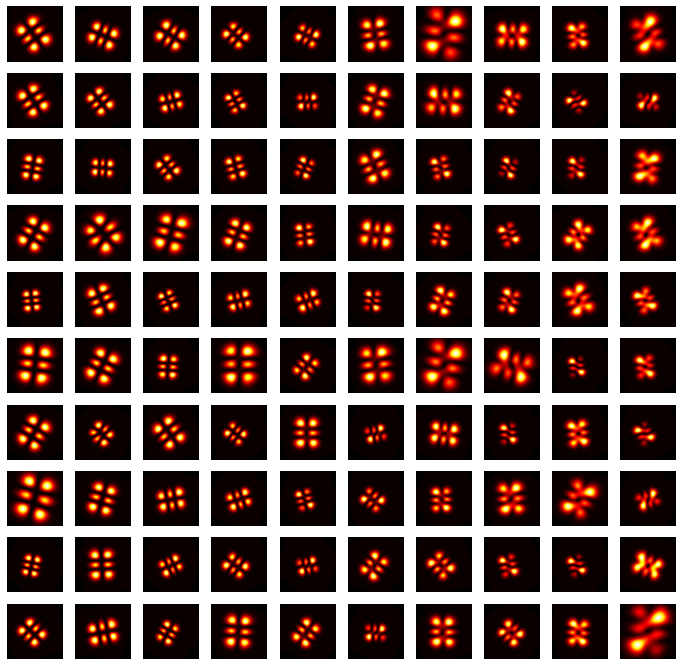

>20, 2101/3000, d=0.406, g=1.739
>20, 2201/3000, d=1.047, g=0.222
>20, 2301/3000, d=0.945, g=2.211
>20, 2401/3000, d=1.011, g=1.295
>20, 2501/3000, d=0.806, g=0.853
>20, 2601/3000, d=0.430, g=1.071
>20, 2701/3000, d=0.731, g=1.246
>20, 2801/3000, d=0.904, g=1.482
>20, 2901/3000, d=0.740, g=1.171


INFO:tensorflow:Assets written to: /raid/rustam/danil/beams_test/beams_gan_train/ep_19/models/i_2999_ep_19/assets


INFO:tensorflow:Assets written to: /raid/rustam/danil/beams_test/beams_gan_train/ep_19/models/i_2999_ep_19/assets


In [26]:
from IPython import display

gen_loss = []
disc_loss = []

for ep in range(epochs):
    iteration = train_size // BATCH_SIZE
    save_path = os.path.join(SAVE_RESULT, f'ep_{ep}')
    os.makedirs(save_path, exist_ok=True)
    for i, (real_images, real_labels) in enumerate(dataset.take(iteration)):
        real_labels = tf.reshape(real_labels, [-1, 1])
        data_losses = cgan_contr.train_step(real_images=real_images, real_labels=real_labels)
        if i % 100 == 0:
            print('>%d, %d/%d, d=%.3f, g=%.3f' %
                (ep+1, i+1, iteration, data_losses['d_loss'], data_losses['g_loss']))
        if i % 1000 == 0:
            display.clear_output(wait=True)
            cbk.on_epoch_end(f'i_{i}_ep_{ep}', save_path=save_path)
        
        if i == (iteration-1): # i % 2400 == 0:
            cbk.save_model(f'{save_path}/models/i_{i}_ep_{ep}')
        
        gen_loss.append(data_losses['g_loss'])
        disc_loss.append(data_losses['d_loss'])
np.save(f'{save_path}/gen_loss.npy', np.asarray(gen_loss))
np.save(f'{save_path}/disc_loss.npy', np.asarray(disc_loss))

# Plot loss graphics

In [ ]:
def get_smoothed_values(data_list, decay=0.99):
    final_values_list = [data_list[0]]
    for elem in data_list[1:]:
        final_values_list.append(
            elem * decay + (1.0 - decay) * final_values_list[-1]
        )
    return final_values_list

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(get_smoothed_values(gen_loss, decay=0.1), color='black')
plt.plot(get_smoothed_values(disc_loss, decay=0.1), color='grey')

plt.xlabel('Количество итераций', fontsize=14)
plt.ylabel('Значение функции ошибки', fontsize=14)

plt.legend(['сеть G', 'сеть D'])
plt.show()

# Save final model

In [ ]:
call = g_model.__call__.get_concrete_function(
    tf.TensorSpec((1, 1), tf.int32, name='label'), tf.TensorSpec((1, LATEN_DIM), tf.float32, name='noise')
)

In [ ]:
tf.saved_model.save(g_model, f'{SAVE_RESULT}/models/last_model', signatures=call)

# Test saved model 

In [ ]:
model = tf.saved_model.load(f'{SAVE_RESULT}/models/last_model')

In [ ]:
random_latent_vectors = np.random.normal(size=(21 * 5, 100)).astype(np.float32)
random_labels = np.asarray([min(x, N_CLASSES-1)  for _ in range(5) for x in range(21)]).astype(np.int32)
generated_images = tf.concat([
    model(label_i=tf.expand_dims(tf.expand_dims(r_l, axis=0), axis=0), noise_i=tf.expand_dims(r_l_v, axis=0))
    for r_l, r_l_v in zip(random_labels, random_latent_vectors)
], axis=0)
# scale from [-1,1] to [0,1]
generated_images = ((generated_images + 1) / 2.0).numpy()

fig, axes = plt.subplots(nrows=5, ncols=21, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
indx = 0
for i, ax in enumerate(axes.flat):
    img = generated_images[i]
    ax.imshow(img)
    label_leg = random_labels[i]
    ax.set_title(label_leg)
    
plt.show()